In [1]:
#"""
#Copyright (c) 2020 Ansys Inc. """

######## IMPORTS ########
# General purpose imports
import os,sys
import numpy as np
import scipy as sp
import json
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
directory=r'%s' %str(Path('__file__').parent.absolute())

#default path for current release 
sys.path.append("C:\\Program Files\\Lumerical\\v232\\api\\python\\") 
sys.path.append("C:\\Program Files\\Lumerical\\v232\\python\\") 
sys.path.append(directory) #Current directory

from lumjson import LumEncoder, LumDecoder

# Optimization specific imports
from lumopt.utilities.load_lumerical_scripts import load_from_lsf
from lumopt.utilities.wavelengths import Wavelengths
from lumopt.geometries.parameterized_geometry import ParameterizedGeometry
from lumopt.geometries.polygon import FunctionDefinedPolygon
from lumopt.figures_of_merit.modematch import ModeMatch
from lumopt.optimizers.generic_optimizers import ScipyOptimizers
from lumopt.optimization import Optimization
from lumopt.optimization import SuperOptimization
from lumopt.utilities.materials import Material
import lumapi
import matplotlib
import matplotlib.pyplot as plt

CONFIGURATION FILE {'root': 'C:\\Program Files\\Lumerical\\v232\\api\\python', 'lumapi': 'C:\\Program Files\\Lumerical\\v232\\api\\python\\'}


In [2]:
directory

'c:\\Users\\Massee\\Desktop\\QCGC\\Lumerical Adjoint'

Accurate interface detection enabled


C:\Program Files\Lumerical\v232\api\python\lumopt\utilities\plotter.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


Running scipy optimizer
bounds = [[-3.   3. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]
 [ 0.1  1. ]]
start = [-2.5         0.02865494  0.54444382  0.03859849  0.53584401  0.04861227
  0.52718348  0.05869709  0.51846149  0.06885381  0.50967733  0.07908327
  0.50083025  0.08938636  0.49191949  0.09976396  0.4829443   0.11021696
  0.47390389  0.1207463   0.46479746  0.1313529   0.45562421  0.1420377
  0.44638332  0.1

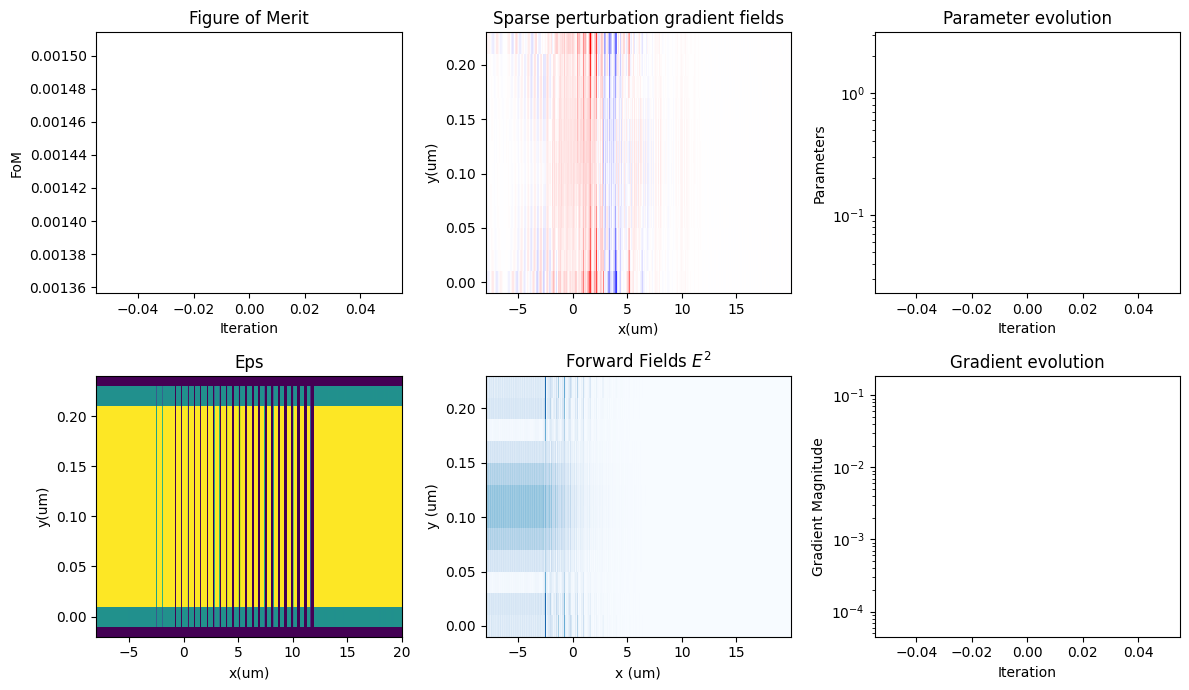

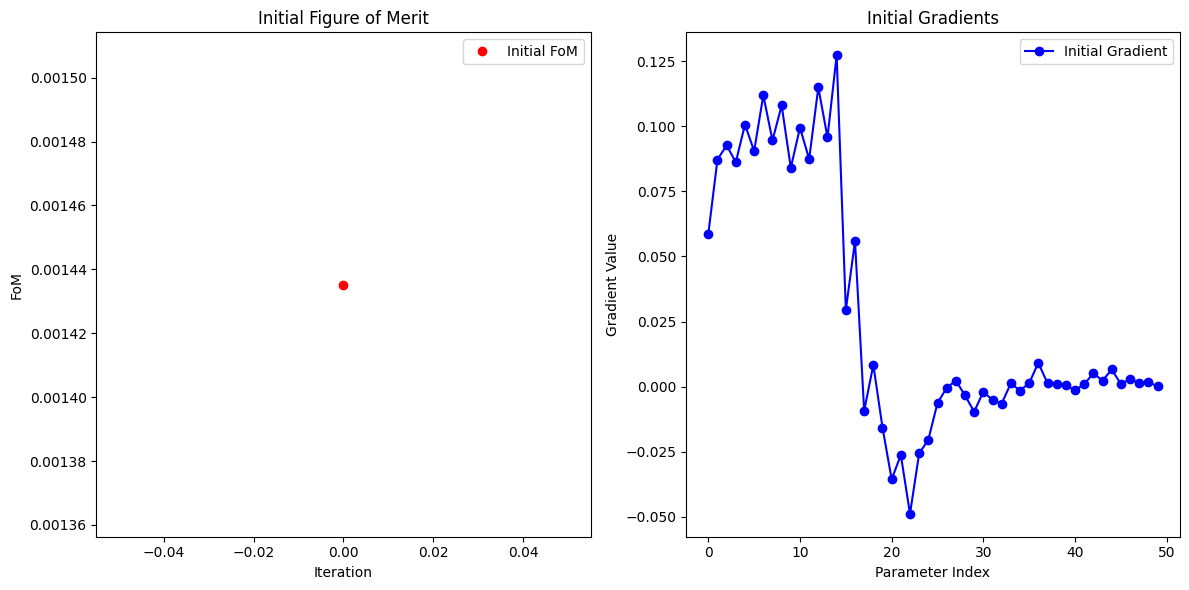

In [3]:
cur_path = directory

# Optimization global parameters
lambda_c = 1.092e-6
bandwidth_in_nm = 0     #< Only optimize for center frequency of 1550nm
F0 = 0.95
height = 220e-9
etch_depth = 220e-9
y0 = 0
x_begin = -5.1e-6
x_end = 22e-6
n_grates = 25

indexSi = 3.47668
indexSiO2 = 1.44401

params_file_apod = "pid_optim_1.json"
params_final = "pid_optim_final.json"
base_sim_2d = "pid_grating_coupler_2D_TE_base.fsp"
base_sim_apodized_2d = "pid_grating_coupler_2D_TE_base_apodized.fsp"
base_script_2d = 'pid_grating_coupler_2D_TE_base.lsf'
sim_2d_final = "pid_grating_coupler_2D_final.fsp"


# Minimal feature size in um. Set to 0.1 to enforce 100nm min features size!
min_feature_size = 0.1

def etched_grating(params, fdtd, update_only = False):
    verts = grating_params_pos(params)

    if not update_only:
        fdtd.addpoly()
        fdtd.set("name", "grating_poly")
        fdtd.setnamed("grating_poly", "x", 0)
        fdtd.setnamed("grating_poly", "y", y0)
        fdtd.set("z",0)
        fdtd.set("z span",0.48e-6)
        fdtd.setnamed("grating_poly", "index", indexSi)
        
    fdtd.setnamed("grating_poly", "vertices", verts)

def grating_params_pos(params, output_waveguide_length = 0.48e-6):
    y3 = y0+height
    y1 = y3-etch_depth

    x0 = params[0]*1e-6     #< First parameter is the starting position

    verts = np.array( [ [x_begin,y0],[x_begin,y3],[x0,y3],[x0,y1] ] )

    ## Iterate over all but the last
    for i in range(n_grates-1):
        x1 = x0 + params[i*2+1]*1e-6    #< Width of the etch
        x2 = x1 + params[i*2+2]*1e-6    #< Width up
        verts = np.concatenate((verts,np.array([[x1,y1],[x1,y3],[x2,y3],[x2,y1]])),axis=0)
        x0 = x2

    x1 = x0 + params[(n_grates-1)*2+1]*1e-6    #< Width of the etch
    # x_end   = x1+output_waveguide_length
    verts = np.concatenate((verts,np.array([[x1,y1],[x1,y3],[x_end,y3],[x_end,y0]])),axis=0)

    return verts


def runGratingOptimization(bandwidth_in_nm, etch_depth, n_grates, initial_params, min_feature_size, working_dir):
### Yet another parametrization which allows to enforce minimum feature size when the optimizer only supports box constraints
### params = [x0, a1, b1, ..., aN]
    if initial_params is None:
        params = np.zeros(2*n_grates)

        for i in range(n_grates):
            params[i*2]   = 0.2     #< Width up
            params[i*2+1] = 0.4*((i+1)/(n_grates+1))     #< Width of the deep etch

            params[0] = 0      #< Overwrite the first since it has a special meaning: Start of the grating at x=0
    else:
        params = initial_params

    bounds = [(min_feature_size, 1)]*(2*n_grates)
    bounds[0] = (-3,3)      #< Bounds for the stating position

    geometry = ParameterizedGeometry(func = etched_grating,
                                   initial_params = params,
                                   bounds = bounds,
                                   dx = 1e-5)

    #geometry = FunctionDefinedPolygon(func = grating_params_pos,
    #initial_params = params,
    #bounds = bounds,
    #z = 0.0,
    #depth = height,
    #eps_out = indexSiO2 ** 2,
    #eps_in = indexSi ** 2,
    #edge_precision = 5,
    #dx = 1e-5)

######## DEFINE FIGURE OF MERIT ########
    fom = ModeMatch(monitor_name = 'fom',
    mode_number = 1,
    direction = 'Forward',
    target_T_fwd = lambda wl: np.ones(wl.size),
    norm_p = 1)

    ######## DEFINE OPTIMIZATION ALGORITHM ########
    optimizer = ScipyOptimizers(max_iter = 1,
    method = 'L-BFGS-B',
    scaling_factor = 1,
    pgtol = 1e-6,
    ftol = 0)


    ######## DEFINE BASE SIMULATION ########
    base_script = load_from_lsf(directory+"\\"+base_script_2d)

######## PUT EVERYTHING TOGETHER ########
    lambda_start = lambda_c*1e9 - bandwidth_in_nm/2
    lambda_end   = lambda_c*1e9 + bandwidth_in_nm/2
    lambda_pts   = int(bandwidth_in_nm/10)+1
    wavelengths = Wavelengths(start = lambda_start*1e-9, stop = lambda_end*1e-9, points = lambda_pts)
    
    opt = Optimization(base_script = base_script,
    wavelengths = wavelengths,
    fom = fom,
    geometry = geometry,
    optimizer = optimizer,
    use_var_fdtd = False,
    hide_fdtd_cad = False,
    use_deps = True,
    plot_history = True,
    store_all_simulations = True,
    save_global_index = False,
    label = None)

######## RUN THE OPTIMIZER ########
    result = opt.run(working_dir=working_dir)

    # Extracting the initial FoM and Gradient
    initial_fom = result[0]
    initial_gradient = result[1]

    # Plotting the Initial FoM and Gradient
    plot_initial_results(initial_fom, initial_gradient)
    
    return result

def plot_initial_results(initial_fom, initial_gradient):
    plt.figure(figsize=(12, 6))

    # Plot the FoM
    plt.subplot(1, 2, 1)
    plt.plot([0], initial_fom, 'ro', label='Initial FoM')
    plt.xlabel('Iteration')
    plt.ylabel('FoM')
    plt.title('Initial Figure of Merit')
    plt.legend()

    # Plot the Gradients
    plt.subplot(1, 2, 2)
    plt.plot(initial_gradient, 'bo-', label='Initial Gradient')
    plt.xlabel('Parameter Index')
    plt.ylabel('Gradient Value')
    plt.title('Initial Gradients')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":

    params_file = params_file_apod
    result_file = params_final
    sim_file = sim_2d_final

with open(directory+"\\"+params_file) as fh:
    initial_params = json.load(fh, cls=LumDecoder)["initial_params"]


working_dir = os.path.join(directory,'FreeGrating_1etch')

opt_result_2D = runGratingOptimization(bandwidth_in_nm=bandwidth_in_nm,
etch_depth=etch_depth,
n_grates = n_grates,
initial_params=initial_params,
min_feature_size=min_feature_size,
working_dir=working_dir)

opt_params_2D = opt_result_2D[1]

with open(os.path.join(cur_path, result_file), "w") as fh:
    json.dump({ "initial_params": opt_params_2D }, fh, cls=LumEncoder, indent = 4)

np.savetxt(os.path.join(cur_path, "apod_2D_params.txt"), opt_params_2D)

######## 2-D SIMULATION WITH OPTIMIZED STRUCTURE ########
with lumapi.FDTD(filename = os.path.join(cur_path, base_sim_2d), hide = True) as fdtd:
    vtx = grating_params_pos(opt_params_2D)
    fdtd.addpoly()
    fdtd.set("vertices", vtx)
    fdtd.set("x", 0)
    fdtd.set("y", 0)
    fdtd.set("z",0)
    fdtd.set("z span",0.48e-6)
    fdtd.set("index", indexSi)
    fdtd.save(os.path.join(cur_path, sim_file))